In [16]:
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels
import matplotlib.pyplot as plt
import dodiscover as dod
import hyppo
import scipy as sp
import sklearn as sk
from sims import *

import matplotlib.gridspec as gridspec

# code taken from https://stackoverflow.com/questions/35042255/how-to-plot-multiple-seaborn-jointplot-in-subplot
class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

# ATE Sims

In [17]:
%%script false --no-raise-error

n = 100
p=101
sims = {"Sigmoidal": sigmoidal_sim, "Linear": linear_sim, "K-Class": kclass_sim}

data_samples = []
data_true = []
for sim, sim_fn in sims.items():
    Ys, Ts, Xs, true_y, true_t, true_x = sim_fn(n, p, causal_effect_size=2, balance=.4)
    df = pd.DataFrame({"Class": Ts, "Measurement" : Ys[:,0], "y2": Ys[:,p-1], "Covariate" : Xs, "Balance":"Unmatched", "Simulation":sim})
    df_true = pd.DataFrame({"Class" : true_t, "Measurement" : true_y[:, 0], "y2" : true_y[:, p-1], "Covariate" : true_x, "Simulation":sim})
    
    balanced_ids = causal_prep(Xs, Ts)
    Xs_bal = Xs[balanced_ids]; Ts_bal = Ts[balanced_ids]; Ys_bal = Ys[balanced_ids,:]
    df_bal = pd.DataFrame({"Class": Ts_bal, "Measurement" : Ys_bal[:,0], "y2": Ys_bal[:,p-1], "Covariate" : Xs_bal, "Balance":"Matched", "Simulation":sim})
    
    data_samples.append(pd.concat((df, df_bal)))
    data_true.append(df_true)

data_samples = pd.concat(data_samples)
data_true = pd.concat(data_true)

In [18]:
%%script false --no-raise-error

def make_subplot(df_dat, df_true, title=""):
    fig = plt.figure(constrained_layout=True);
    widths = [2, .5]
    heights = [.5, 2]
    spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights);
    
    ax = fig.add_subplot(spec[0, 0]);
    palette=sns.color_palette("deep", 3)
    g = sns.histplot(data=df_dat, x="Covariate", ax=ax, hue="Class", palette=palette, legend=False, binwidth=0.1)
    g.set(xlabel=None, xticks=[], yticks=[], ylabel=None, xlim=(-1, 1))
    ax = fig.add_subplot(spec[1, 0]);
    g = sns.scatterplot(data=df_dat, x="Covariate", y="Measurement", hue="Class", ax=ax, alpha=0.5, palette=palette)
    ax.set_xlim(-1, 1)
    
    ylim = (np.min((np.min(df_true["Measurement"]), np.min(df_dat["Measurement"]))), np.max((np.max(df_true["Measurement"]), np.max(df_dat["Measurement"]))))
    sns.lineplot(data=df_true, x="Covariate", y="Measurement", hue="Class", ax=ax, linewidth=3, palette=palette, legend=False)
    ax = fig.add_subplot(spec[1, 1]);
    g = sns.histplot(data=df_dat, y="Measurement", ax=ax, hue="Class", palette=palette, legend=False, bins=20, orientation="horizontal")
    g.set(xlabel=None, xticks=[], yticks=[], ylabel=None, ylim=ylim)
    
    
    return fig


df_dat = data_samples[(data_samples["Simulation"] == "Linear") & (data_samples["Balance"] == "Unmatched")]
df_tru = data_true[data_true["Simulation"] == "Linear"]
g11 = make_subplot(data_samples[(data_samples["Simulation"] == "Linear") & (data_samples["Balance"] == "Unmatched")], data_true[data_true["Simulation"] == "Linear"])
g21 = make_subplot(data_samples[(data_samples["Simulation"] == "Linear") & (data_samples["Balance"] == "Matched")], data_true[data_true["Simulation"] == "Linear"])
g12 = make_subplot(data_samples[(data_samples["Simulation"] == "Sigmoidal") & (data_samples["Balance"] == "Unmatched")], data_true[data_true["Simulation"] == "Sigmoidal"])
g22 = make_subplot(data_samples[(data_samples["Simulation"] == "Sigmoidal") & (data_samples["Balance"] == "Matched")], data_true[data_true["Simulation"] == "Sigmoidal"])
g13 = make_subplot(data_samples[(data_samples["Simulation"] == "K-Class") & (data_samples["Balance"] == "Unmatched")], data_true[data_true["Simulation"] == "K-Class"])
g23 = make_subplot(data_samples[(data_samples["Simulation"] == "K-Class") & (data_samples["Balance"] == "Matched")], data_true[data_true["Simulation"] == "K-Class"])

# CATE Sims

In [19]:
n = 2000
p=10
pref = 1
sims = {"Heteroskedastic" : heteroskedastic_cate, "Function" : diff_fn_cate, "Sigmoidal": sigmoidal_sim_cate, 
        "Non-Monotone": nonmonotonic_sim_cate, "K-Class": kclass_rotation_cate}

data_samples = []
data_true = []
for sim, sim_fn in sims.items():
    if sim == "K-Class" or sim == "Sigmoidal":
        covar_sz = 5
    elif sim == "Function":
        covar_sz = 7
    elif sim == "Heteroskedastic":
        covar_sz = 5
    else:
        covar_sz = 1
    Ys, Ts, Xs, true_y, true_t, true_x = sim_fn(n, p, causal_effect_size=1, covar_effect_size = covar_sz, balance=.4)
    df = pd.DataFrame({"ID" : range(0, n), "Group": Ts, "Outcome" : Ys[:,pref], "Covariate" : Xs, "Balance":"Unmatched", "Simulation":sim})
    df_true = pd.DataFrame({"Group" : true_t, "Outcome" : true_y[:, pref], "Covariate" : true_x, "Simulation":sim})
    
    balanced_ids = causal_prep(Xs, Ts)
    Xs_bal = Xs[balanced_ids]; Ts_bal = Ts[balanced_ids]; Ys_bal = Ys[balanced_ids,:]
    df_bal = pd.DataFrame({"ID": np.where(balanced_ids)[0], "Group": Ts_bal, "Outcome" : Ys_bal[:,pref], "Covariate" : Xs_bal, "Balance":"Matched", "Simulation":sim})
    
    data_samples.append(pd.concat((df, df_bal)))
    data_true.append(df_true)

data_samples = pd.concat(data_samples)
data_true = pd.concat(data_true)

Optimization terminated successfully.
         Current function value: 0.379243
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.379817
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.389568
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411137
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.739237
         Iterations 7


In [20]:
def make_subplot(df_dat, df_true, samples=None, title="", rsamp=None, ylim=(-5, 5)):
    if samples is None:
        samples = range(0, df_dat.shape[0])
    
    fig = plt.figure(constrained_layout=True, figsize=(3, 2.5));
    widths = [2, .5]
    heights = [.5, 2]
    spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights);
    
    ax = fig.add_subplot(spec[0, 0]);
    palette=sns.color_palette("deep", 3)
    g = sns.histplot(data=df_dat, x="Covariate", ax=ax, hue="Group", stat="density", common_norm=False, palette=palette, legend=False, bins=30)
    g.set(xlabel=None, xticks=[], yticks=[], ylabel=None, xlim=(-1, 1))
    ax = fig.add_subplot(spec[1, 0]);
    g = sns.scatterplot(data=df_dat[np.in1d(df_dat["ID"], samples)], x="Covariate", y="Outcome", hue="Group", ax=ax, alpha=0.5, legend=False, palette=palette)
    ax.set_xlim(-1, 1)
    ax.set(ylim=ylim)
    
    ylim = (np.min((np.min(df_true["Outcome"]), np.min(df_dat["Outcome"]))), np.max((np.max(df_true["Outcome"]), np.max(df_dat["Outcome"]))))
    sns.lineplot(data=df_true, x="Covariate", y="Outcome", hue="Group", ax=ax, linewidth=3, palette=palette, legend=False)
    ax = fig.add_subplot(spec[1, 1]);
    g = sns.histplot(data=df_dat, y="Outcome", ax=ax, hue="Group", stat="density", common_norm=False, palette=palette, legend=False, bins=30, orientation="horizontal")
    g.set(xlabel=None, xticks=[], yticks=[], ylabel=None)
    
    return fig


/var/folders/r_/8hcfnmrs7z5160l03b04bjpw0000gn/T/ipykernel_25461/2014109935.py:12: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  g = sns.histplot(data=df_dat, x="Covariate", ax=ax, hue="Group", stat="density", common_norm=False, palette=palette, legend=False, bins=30)
/var/folders/r_/8hcfnmrs7z5160l03b04bjpw0000gn/T/ipykernel_25461/2014109935.py:15: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  g = sns.scatterplot(data=df_dat[np.in1d(df_dat["ID"], samples)], x="Covariate", y="Outcome", hue="Group", ax=ax, alpha=0.5, legend=False, palette=palette)
/var/folders/r_/8hcfnmrs7z5160l03b04bjpw0000gn/T/ipykernel_25461/2014109935.py:20: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.lineplot(data=df_true, x="Covariate", y="Outcome", hue="Group", ax=ax, linewidth=3, palette=palette, legend=False)
/var/folders/r_/8hcfnmrs7z5160l03b04bjpw0000gn/T/

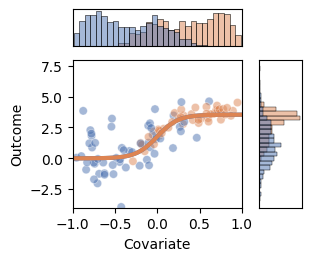

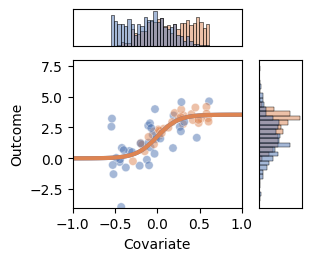

In [21]:
samples = np.random.choice(n, 100, replace=False)
g11 = make_subplot(data_samples[(data_samples["Simulation"] == "Heteroskedastic") & (data_samples["Balance"] == "Unmatched")],
                   data_true[data_true["Simulation"] == "Heteroskedastic"], samples=samples, ylim=(-4, 8))
g11.savefig("Figures/Temporary/Heteroum.pdf")
g21 = make_subplot(data_samples[(data_samples["Simulation"] == "Heteroskedastic") & (data_samples["Balance"] == "Matched")],
                   data_true[data_true["Simulation"] == "Heteroskedastic"], samples=samples, ylim=(-4, 8))
g21.savefig("Figures/Temporary/Heteron.pdf")

/var/folders/r_/8hcfnmrs7z5160l03b04bjpw0000gn/T/ipykernel_25461/2014109935.py:12: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  g = sns.histplot(data=df_dat, x="Covariate", ax=ax, hue="Group", stat="density", common_norm=False, palette=palette, legend=False, bins=30)
/var/folders/r_/8hcfnmrs7z5160l03b04bjpw0000gn/T/ipykernel_25461/2014109935.py:15: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  g = sns.scatterplot(data=df_dat[np.in1d(df_dat["ID"], samples)], x="Covariate", y="Outcome", hue="Group", ax=ax, alpha=0.5, legend=False, palette=palette)
/var/folders/r_/8hcfnmrs7z5160l03b04bjpw0000gn/T/ipykernel_25461/2014109935.py:20: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.lineplot(data=df_true, x="Covariate", y="Outcome", hue="Group", ax=ax, linewidth=3, palette=palette, legend=False)
/var/folders/r_/8hcfnmrs7z5160l03b04bjpw0000gn/T/

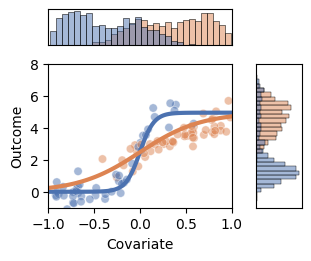

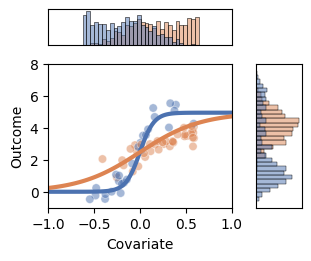

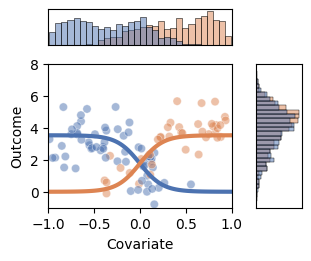

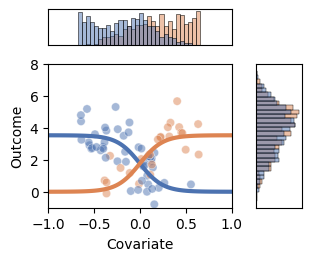

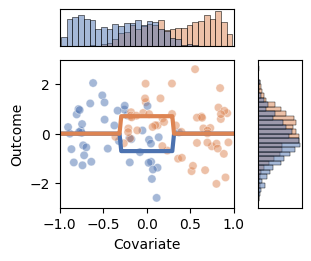

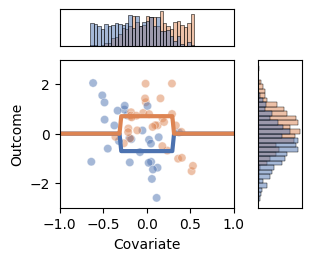

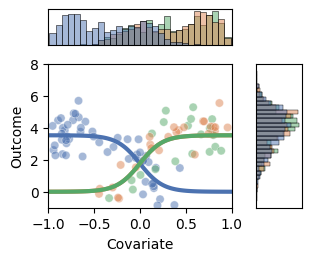

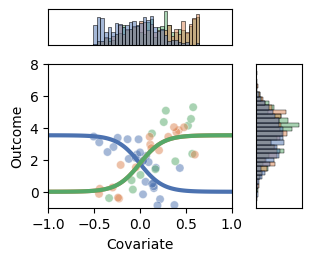

In [22]:
g11 = make_subplot(data_samples[(data_samples["Simulation"] == "Function") & (data_samples["Balance"] == "Unmatched")],
                   data_true[data_true["Simulation"] == "Function"], samples=samples, ylim=(-1, 8))
g11.savefig("Figures/Temporary/Difffnum.pdf")
g21 = make_subplot(data_samples[(data_samples["Simulation"] == "Function") & (data_samples["Balance"] == "Matched")],
                   data_true[data_true["Simulation"] == "Function"], samples=samples, ylim=(-1, 8))
g21.savefig("Figures/Temporary/Difffnm.pdf")
g11 = make_subplot(data_samples[(data_samples["Simulation"] == "Sigmoidal") & (data_samples["Balance"] == "Unmatched")],
                   data_true[data_true["Simulation"] == "Sigmoidal"], samples=samples, ylim=(-1, 8))
g11.savefig("Figures/Temporary/Sigmoidalum.pdf")
g21 = make_subplot(data_samples[(data_samples["Simulation"] == "Sigmoidal") & (data_samples["Balance"] == "Matched")],
                   data_true[data_true["Simulation"] == "Sigmoidal"], samples=samples, ylim=(-1, 8))
g21.savefig("Figures/Temporary/Sigmoidalm.pdf")
g12 = make_subplot(data_samples[(data_samples["Simulation"] == "Non-Monotone") & (data_samples["Balance"] == "Unmatched")],
                   data_true[data_true["Simulation"] == "Non-Monotone"], samples=samples, ylim=(-3, 3))
g12.savefig("Figures/Temporary/Nonmonotoneum.pdf")
g22 = make_subplot(data_samples[(data_samples["Simulation"] == "Non-Monotone") & (data_samples["Balance"] == "Matched")],
                   data_true[data_true["Simulation"] == "Non-Monotone"], samples=samples, ylim=(-3, 3))
g22.savefig("Figures/Temporary/Nonmonotonem.pdf")
g13 = make_subplot(data_samples[(data_samples["Simulation"] == "K-Class") & (data_samples["Balance"] == "Unmatched")],
                   data_true[data_true["Simulation"] == "K-Class"], samples=samples, ylim=(-1, 8))
g13.savefig("Figures/Temporary/Kclasssum.pdf")
g23 = make_subplot(data_samples[(data_samples["Simulation"] == "K-Class") & (data_samples["Balance"] == "Matched")],
                   data_true[data_true["Simulation"] == "K-Class"],samples=samples,  ylim=(-1, 8))
g23.savefig("Figures/Temporary/Kclassm.pdf")

###### Supplement Figures

## Covariate Construction and Matching

/var/folders/r_/8hcfnmrs7z5160l03b04bjpw0000gn/T/ipykernel_25461/1773322233.py:7: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.histplot(data=pd.DataFrame({"Covariate": Xs, "Group": Ts}), x="Covariate", hue="Group", fill="Group", stat="proportion", palette=palette, bins=30, ax=axs[0])


Optimization terminated successfully.
         Current function value: 0.390548
         Iterations 7


/var/folders/r_/8hcfnmrs7z5160l03b04bjpw0000gn/T/ipykernel_25461/1773322233.py:16: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.histplot(data=pd.DataFrame({"Covariate": Xs_bal, "Group": Ts_bal}), x="Covariate", hue="Group", fill="Group", palette=palette, stat="proportion", bins=30, ax=axs[1])


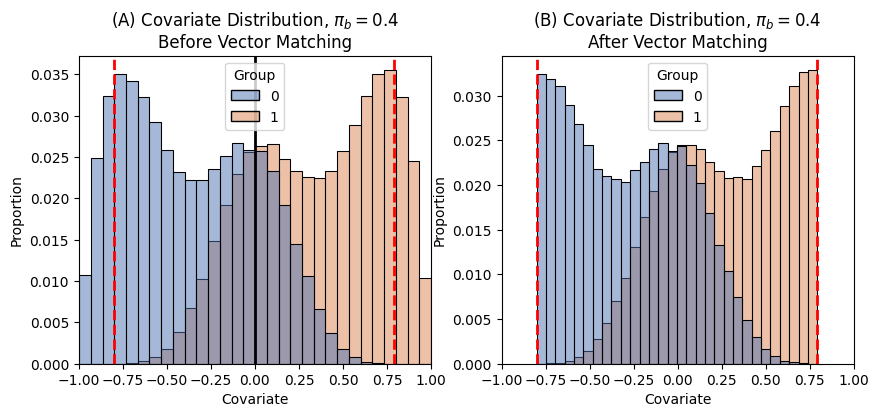

In [24]:
n = 500000
pi = 0.5
Ts = np.random.binomial(1, pi, size=n)
Xs = simulate_covars(Ts, balance=0.4)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
palette=sns.color_palette("deep", 3)
sns.histplot(data=pd.DataFrame({"Covariate": Xs, "Group": Ts}), x="Covariate", hue="Group", fill="Group", stat="proportion", palette=palette, bins=30, ax=axs[0])
axs[0].set(xlim=(-1, 1), title="(A) Covariate Distribution, $\\pi_b = 0.4$\nBefore Vector Matching")
xmin_loc = np.min(Xs[Ts == 1])
xmax_loc = np.max(Xs[Ts == 0])
axs[0].axvline(x=xmin_loc, color="red", linestyle="--", linewidth=2)
axs[0].axvline(x=xmax_loc, color="red", linestyle="--", linewidth=2)
axs[0].axvline(x=0, color="black", linewidth=2)
balance_ids = causal_prep(Xs, Ts)
Xs_bal = Xs[balance_ids]; Ts_bal = Ts[balance_ids]
sns.histplot(data=pd.DataFrame({"Covariate": Xs_bal, "Group": Ts_bal}), x="Covariate", hue="Group", fill="Group", palette=palette, stat="proportion", bins=30, ax=axs[1])
axs[1].set(xlim=(-1, 1), title="(B) Covariate Distribution, $\\pi_b = 0.4$\nAfter Vector Matching")
axs[1].axvline(x=xmin_loc, color="red", linestyle="--", linewidth=2)
axs[1].axvline(x=xmax_loc, color="red", linestyle="--", linewidth=2)
fig.savefig("./Figures/vm.pdf")

## Sigmoidal Sim

/var/folders/r_/8hcfnmrs7z5160l03b04bjpw0000gn/T/ipykernel_25461/865980393.py:25: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(data=data_samples[data_samples["Effect Size"] == effsz], x="Covariate", y="Measurement", hue="Group", ax=axs[i], alpha=0.5, legend = leg, palette=palette)
/var/folders/r_/8hcfnmrs7z5160l03b04bjpw0000gn/T/ipykernel_25461/865980393.py:29: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.lineplot(data=data_true[data_true["Effect Size"] == effsz], x="Covariate", y="Measurement", hue="Group", ax=axs[i], linewidth=3, palette=palette, legend=False)
/var/folders/r_/8hcfnmrs7z5160l03b04bjpw0000gn/T/ipykernel_25461/865980393.py:25: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(data=data_samples[data_samples["Effect Size"] == effsz], x="Covariate", y="Measurement", hue="Group", ax=axs[i], al

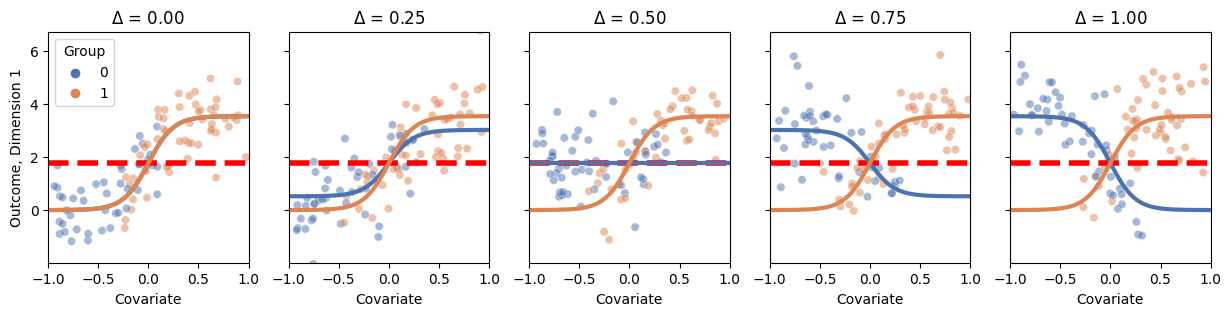

In [35]:
n = 100
p = 10
effect_szs = np.linspace(0, 1, 5)

covar_sz = 5
data_samples = []
data_true = []
for effsz in effect_szs:
    Ys, Ts, Xs, true_y, true_t, true_x = sigmoidal_sim_cate(n, p, causal_effect_size=effsz, covar_effect_size = covar_sz, balance=.4)
    df = pd.DataFrame({"Group": Ts, "Measurement" : Ys[:,pref], "Covariate" : Xs, "Balance":"Unmatched", "Effect Size":effsz})
    df_true = pd.DataFrame({"Group" : true_t, "Measurement" : true_y[:, pref], "Covariate" : true_x, "Effect Size":effsz})

    data_samples.append(df)
    data_true.append(df_true)

data_samples = pd.concat(data_samples)
data_true = pd.concat(data_true)

fig, axs = plt.subplots(1, len(effect_szs), figsize=(15, 3))
for i, effsz in enumerate(effect_szs):
    if i > 0:
        leg = False
    else:
        leg = True
    sns.scatterplot(data=data_samples[data_samples["Effect Size"] == effsz], x="Covariate", y="Measurement", hue="Group", ax=axs[i], alpha=0.5, legend = leg, palette=palette)
    axs[i].set_xlim(-1, 1)
    axs[i].axhline(5/(2*np.sqrt(2)), color="red", linewidth=4, linestyle="--")

    sns.lineplot(data=data_true[data_true["Effect Size"] == effsz], x="Covariate", y="Measurement", hue="Group", ax=axs[i], linewidth=3, palette=palette, legend=False)
    axs[i].set_title("$\\Delta$ = {:.2f}".format(effsz))
    axs[i].set_ylabel("Outcome, Dimension 1")
    if i > 0:
        axs[i].set(yticklabels=[], ylabel="")
    axs[i].set_ylim((np.min(data_samples["Measurement"] + .05), np.max(data_samples["Measurement"]) - .05))

fig.savefig("./Figures/Sigmoidal.pdf")

## Non-Monotone

/var/folders/r_/8hcfnmrs7z5160l03b04bjpw0000gn/T/ipykernel_25461/4086779383.py:25: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(data=data_samples[data_samples["Effect Size"] == effsz], x="Covariate", y="Measurement", hue="Group", ax=axs[i], alpha=0.5, legend = leg, palette=palette)
/var/folders/r_/8hcfnmrs7z5160l03b04bjpw0000gn/T/ipykernel_25461/4086779383.py:28: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.lineplot(data=data_true[data_true["Effect Size"] == effsz], x="Covariate", y="Measurement", hue="Group", ax=axs[i], linewidth=3, palette=palette, legend=False)
/var/folders/r_/8hcfnmrs7z5160l03b04bjpw0000gn/T/ipykernel_25461/4086779383.py:25: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(data=data_samples[data_samples["Effect Size"] == effsz], x="Covariate", y="Measurement", hue="Group", ax=axs[i],

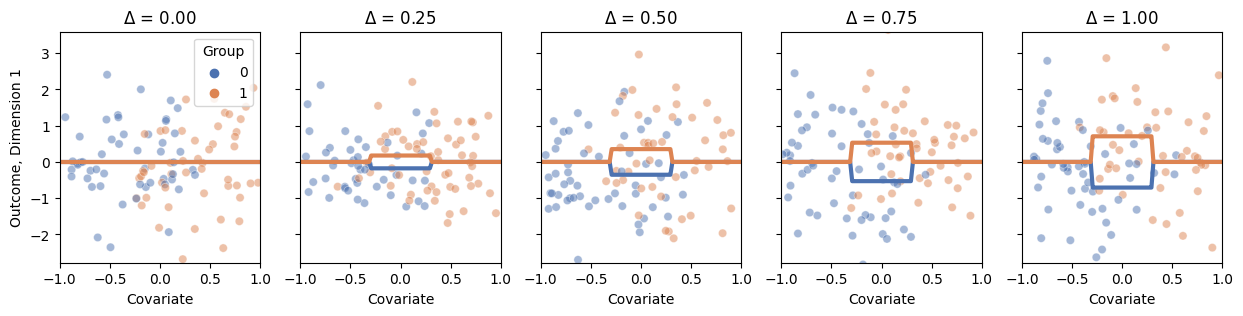

In [26]:
n = 100
p = 10
effect_szs = np.linspace(0, 1, 5)

covar_sz = 1
data_samples = []
data_true = []
for effsz in effect_szs:
    Ys, Ts, Xs, true_y, true_t, true_x = nonmonotonic_sim_cate(n, p, causal_effect_size=effsz, covar_effect_size = covar_sz, balance=.4)
    df = pd.DataFrame({"Group": Ts, "Measurement" : Ys[:,pref], "Covariate" : Xs, "Balance":"Unmatched", "Effect Size":effsz})
    df_true = pd.DataFrame({"Group" : true_t, "Measurement" : true_y[:, pref], "Covariate" : true_x, "Effect Size":effsz})

    data_samples.append(df)
    data_true.append(df_true)

data_samples = pd.concat(data_samples)
data_true = pd.concat(data_true)

fig, axs = plt.subplots(1, len(effect_szs), figsize=(15, 3))
for i, effsz in enumerate(effect_szs):
    if i > 0:
        leg = False
    else:
        leg = True
    sns.scatterplot(data=data_samples[data_samples["Effect Size"] == effsz], x="Covariate", y="Measurement", hue="Group", ax=axs[i], alpha=0.5, legend = leg, palette=palette)
    axs[i].set_xlim(-1, 1)

    sns.lineplot(data=data_true[data_true["Effect Size"] == effsz], x="Covariate", y="Measurement", hue="Group", ax=axs[i], linewidth=3, palette=palette, legend=False)
    axs[i].set_title("$\\Delta$ = {:.2f}".format(effsz))
    axs[i].set_ylabel("Outcome, Dimension 1")
    if i > 0:
        axs[i].set(yticklabels=[], ylabel="")
    axs[i].set_ylim((np.min(data_samples["Measurement"] + .05), np.max(data_samples["Measurement"]) - .05))

fig.savefig("./Figures/Nonmonotone.pdf")

## K-Class

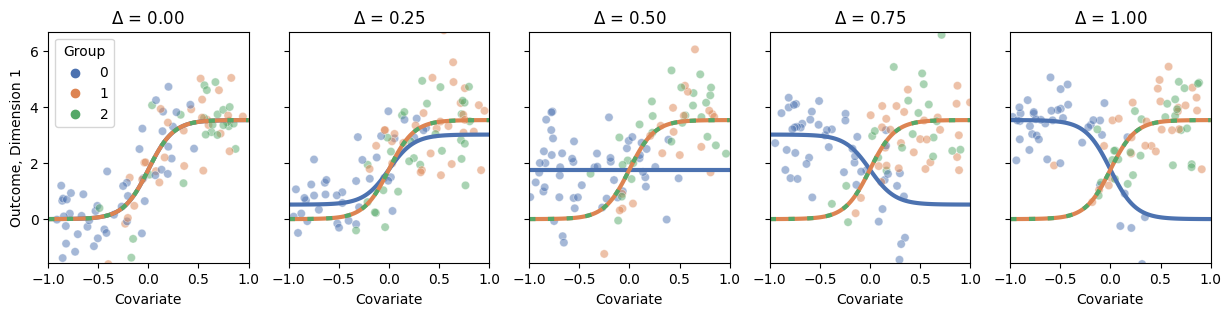

In [27]:
n = 100
p = 10
effect_szs = np.linspace(0, 1, 5)

covar_sz = 5
data_samples = []
data_true = []
for effsz in effect_szs:
    Ys, Ts, Xs, true_y, true_t, true_x = kclass_rotation_cate(n, p, causal_effect_size=effsz, covar_effect_size = covar_sz, balance=.4)
    df = pd.DataFrame({"Group": Ts, "Measurement" : Ys[:,pref], "Covariate" : Xs, "Balance":"Unmatched", "Effect Size":effsz})
    df_true = pd.DataFrame({"Group" : true_t, "Measurement" : true_y[:, pref], "Covariate" : true_x, "Effect Size":effsz})

    data_samples.append(df)
    data_true.append(df_true)

data_samples = pd.concat(data_samples)
data_true = pd.concat(data_true)

linestyles={0: "", 1 : "",
         2: (1.5, 3)}

fig, axs = plt.subplots(1, len(effect_szs), figsize=(15, 3))
for i, effsz in enumerate(effect_szs):
    if i > 0:
        leg = False
    else:
        leg = True
    sns.scatterplot(data=data_samples[data_samples["Effect Size"] == effsz], x="Covariate", y="Measurement", hue="Group", ax=axs[i], alpha=0.5, legend = leg, palette=palette)
    axs[i].set_xlim(-1, 1)

    sns.lineplot(data=data_true[data_true["Effect Size"] == effsz], x="Covariate", y="Measurement", hue="Group", ax=axs[i], linewidth=3, palette=palette, 
                 style="Group", dashes=linestyles, legend=False)
    axs[i].set_title("$\\Delta$ = {:.2f}".format(effsz))
    axs[i].set_ylabel("Outcome, Dimension 1")
    if i > 0:
        axs[i].set(yticklabels=[], ylabel="")
    axs[i].set_ylim((np.min(data_samples["Measurement"] + .05), np.max(data_samples["Measurement"]) - .05))

fig.savefig("./Figures/Kclass.pdf")

## Heteroskedastic

/var/folders/r_/8hcfnmrs7z5160l03b04bjpw0000gn/T/ipykernel_25461/3408376098.py:25: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(data=data_samples[data_samples["Effect Size"] == effsz], x="Covariate", y="Measurement", hue="Group", ax=axs[i], alpha=0.5, legend = leg, palette=palette)
/var/folders/r_/8hcfnmrs7z5160l03b04bjpw0000gn/T/ipykernel_25461/3408376098.py:28: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.lineplot(data=data_true[data_true["Effect Size"] == effsz], x="Covariate", y="Measurement", hue="Group", ax=axs[i], linewidth=3, palette=palette, legend=False)
/var/folders/r_/8hcfnmrs7z5160l03b04bjpw0000gn/T/ipykernel_25461/3408376098.py:25: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(data=data_samples[data_samples["Effect Size"] == effsz], x="Covariate", y="Measurement", hue="Group", ax=axs[i],

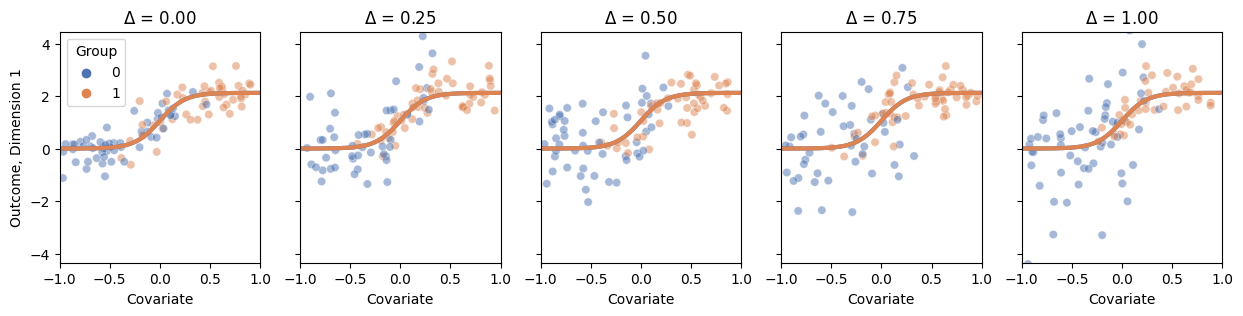

In [30]:
n = 100
p = 10
effect_szs = np.linspace(0, 1, 5)

covar_sz = 3
data_samples = []
data_true = []
for effsz in effect_szs:
    Ys, Ts, Xs, true_y, true_t, true_x = heteroskedastic_cate(n, p, causal_effect_size=effsz, covar_effect_size = covar_sz, balance=.4)
    df = pd.DataFrame({"Group": Ts, "Measurement" : Ys[:,pref], "Covariate" : Xs, "Balance":"Unmatched", "Effect Size":effsz})
    df_true = pd.DataFrame({"Group" : true_t, "Measurement" : true_y[:, pref], "Covariate" : true_x, "Effect Size":effsz})

    data_samples.append(df)
    data_true.append(df_true)

data_samples = pd.concat(data_samples)
data_true = pd.concat(data_true)

fig, axs = plt.subplots(1, len(effect_szs), figsize=(15, 3))
for i, effsz in enumerate(effect_szs):
    if i > 0:
        leg = False
    else:
        leg = True
    sns.scatterplot(data=data_samples[data_samples["Effect Size"] == effsz], x="Covariate", y="Measurement", hue="Group", ax=axs[i], alpha=0.5, legend = leg, palette=palette)
    axs[i].set_xlim(-1, 1)

    sns.lineplot(data=data_true[data_true["Effect Size"] == effsz], x="Covariate", y="Measurement", hue="Group", ax=axs[i], linewidth=3, palette=palette, legend=False)
    axs[i].set_title("$\\Delta$ = {:.2f}".format(effsz))
    axs[i].set_ylabel("Outcome, Dimension 1")
    if i > 0:
        axs[i].set(yticklabels=[], ylabel="")
    axs[i].set_ylim((np.min(data_samples["Measurement"] + .05), np.max(data_samples["Measurement"]) - .05))

fig.savefig("./Figures/Heteroskedastic.pdf")

In [ ]:
n = 300; p = 10; covar_sz = 5
Y, T, X, true_y, true_t, true_x = sigmoidal_sim_cate(n, p, causal_effect_size=0,covar_effect_size = 5, balance=.8)
np.savetxt("./data/sigsim_Y_null.csv", Y)
np.savetxt("./data/sigsim_T_null.csv", T)
np.savetxt("./data/sigsim_X_null.csv", X)
stat, pval = cond_manova(Y, T, X)
print(float(stat), float(pval))

Y, T, X, true_y, true_t, true_x = kclass_rotation_cate(n, p, causal_effect_size=1,covar_effect_size = 5, balance=.8)
np.savetxt("./data/sigsim_Y_effect.csv", Y)
np.savetxt("./data/sigsim_T_effect.csv", T)
np.savetxt("./data/sigsim_X_effect.csv", X)
stat, pval = cond_manova(Y, T, X)
print(float(stat), float(pval))

In [ ]:
output[0]

In [ ]:
output[1]